<a href="https://colab.research.google.com/github/Abhishekjadhav64/Sentiment-Analysis-for-Mental-Health---NLP/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

#Loadind the Dataset

In [7]:
data=pd.read_csv("/content/sample_data/Combined Data.csv")

In [8]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [9]:
# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0'])

# Check for and handle missing values
print(data.isnull().sum())

# Fill or drop missing values as appropriate
data = data.dropna()

# Example of text cleaning
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

data['statement'] = data['statement'].apply(clean_text)

statement    362
status         0
dtype: int64


#Exploratoey Data Analysis(EDA)

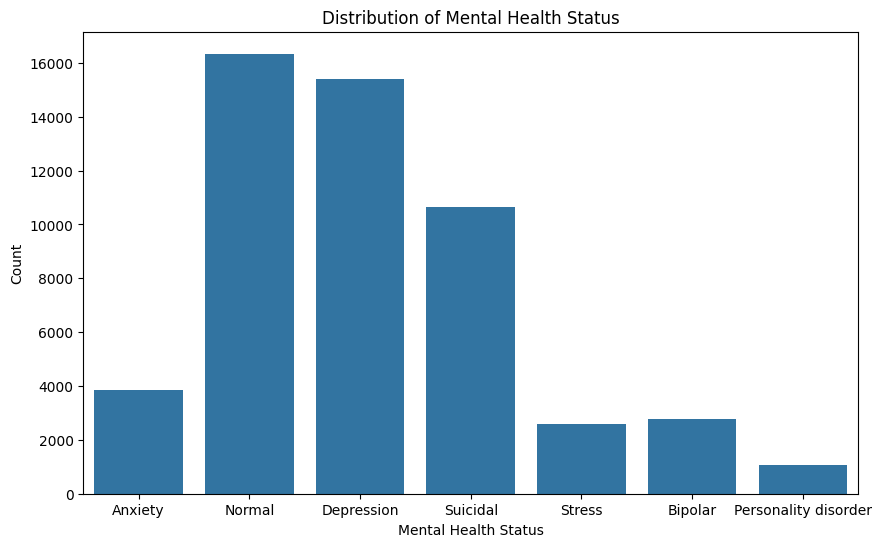

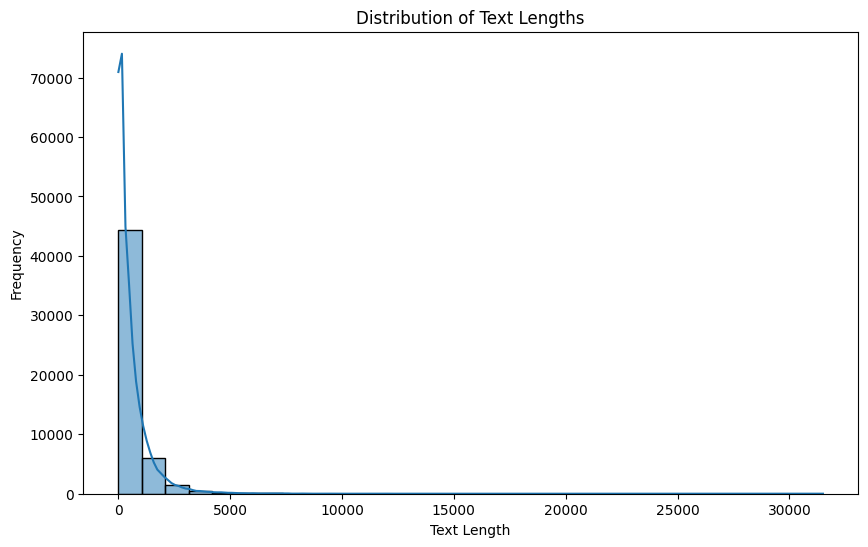

In [10]:
# Distribution of statuses
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='status')
plt.title('Distribution of Mental Health Status')
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.show()

# Text length distribution
data['text_length'] = data['statement'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

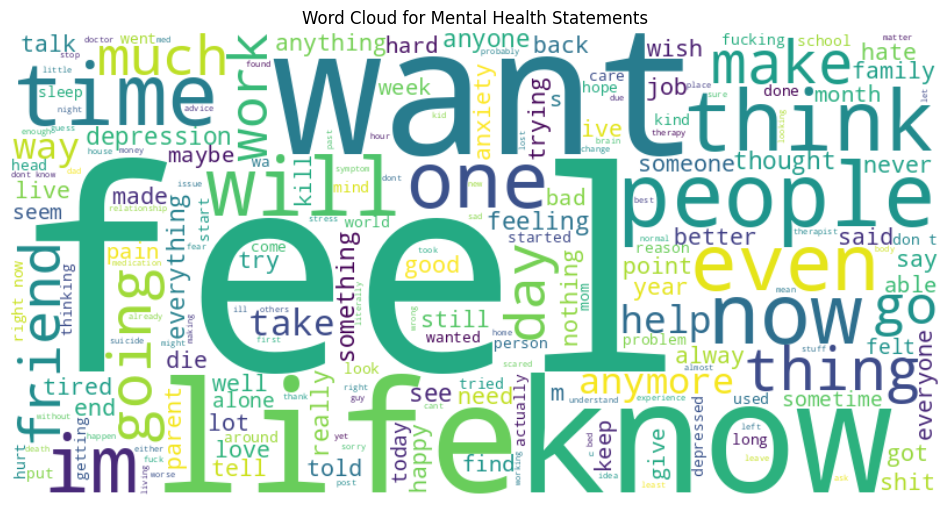

Top 10 most common words:
just: 48822
like: 38270
feel: 31595
want: 27294
know: 23541
life: 22171
im: 21576
time: 17904
people: 16526
really: 16372


In [11]:
from wordcloud import WordCloud

# Generate a word cloud for the entire dataset
text = ' '.join(data['statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Mental Health Statements')
plt.show()

# Display most common words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['statement'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Print top 10 most common words
print("Top 10 most common words:")
for word, freq in sorted_word_freq[:10]:
    print(f"{word}: {freq}")

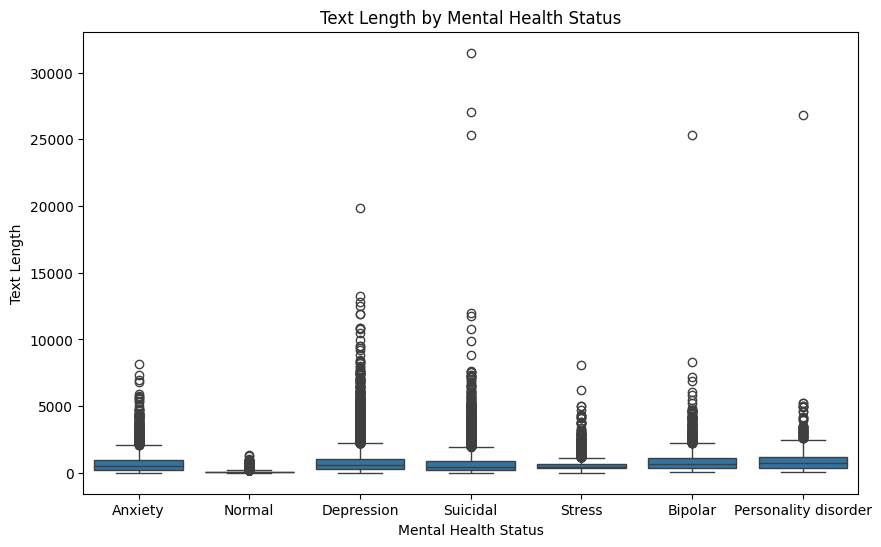

Correlation Matrix:
                text_length  status_numeric
text_length        1.000000       -0.032795
status_numeric    -0.032795        1.000000


In [12]:
# Analyze the correlation between text length and mental health status
import numpy as np

# Convert categorical labels to numeric
data['status_numeric'] = pd.Categorical(data['status']).codes

# Plot the relationship between text length and status
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='status', y='text_length')
plt.title('Text Length by Mental Health Status')
plt.xlabel('Mental Health Status')
plt.ylabel('Text Length')
plt.show()

# Compute correlation matrix
correlation_matrix = data[['text_length', 'status_numeric']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

#MODELLING


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define features and target
X = data['statement']
y = data['status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create a pipeline with TF-IDF and Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)),
    ('nb', MultinomialNB())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Perform cross-validation with stratified folds
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
print("Confusion Matrix:")
print(conf_matrix)

# Analyze misclassifications
errors = pd.DataFrame({
    'Statement': X_test,
    'True Label': y_test,
    'Predicted Label': y_pred
})

# Filter to show only misclassified samples
misclassified = errors[errors['True Label'] != errors['Predicted Label']]
print("\nMisclassified Samples:")
print(misclassified.head(10))

Accuracy: 0.6869977855109143
                      precision    recall  f1-score   support

             Anxiety       0.79      0.65      0.71      1152
             Bipolar       0.90      0.49      0.63       833
          Depression       0.56      0.79      0.65      4622
              Normal       0.80      0.83      0.82      4903
Personality disorder       1.00      0.04      0.08       323
              Stress       0.92      0.11      0.20       776
            Suicidal       0.71      0.59      0.64      3196

            accuracy                           0.69     15805
           macro avg       0.81      0.50      0.53     15805
        weighted avg       0.73      0.69      0.67     15805

Cross-Validation Accuracy: 0.6508229831041918 ± 0.032502188505575735
Confusion Matrix:
[[ 745   16  201  183    0    4    3]
 [  33  405  286  103    0    1    5]
 [  40   14 3646  255    0    0  667]
 [  29    3  690 4092    0    2   87]
 [   6    6  227   67   13    0    4]
 [  89   

In [24]:
# Sample data for testing
sample_statements = [
    "I feel fantastic today!",
    "I'm struggling with anxiety and depression.",
    "Life is going well, and I'm feeling positive.",
    "I'm overwhelmed and don't know how to cope.",
    "Everything seems so hopeless right now."
]

# Predict sentiment for the sample data
predictions = pipeline.predict(sample_statements)

# Print the results
for statement, prediction in zip(sample_statements, predictions):
    print(f"Statement: {statement}\nPredicted Sentiment: {prediction}\n")

Statement: I feel fantastic today!
Predicted Sentiment: Normal

Statement: I'm struggling with anxiety and depression.
Predicted Sentiment: Depression

Statement: Life is going well, and I'm feeling positive.
Predicted Sentiment: Depression

Statement: I'm overwhelmed and don't know how to cope.
Predicted Sentiment: Depression

Statement: Everything seems so hopeless right now.
Predicted Sentiment: Depression

